In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 1
num_workers = 2
epochs = 4
learning_rate = 0.01
betas = (0.9, 0.999)
PATH = '../data/saved_model/GAN.pth'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root = '../data', train=True,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.MNIST(root = '../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
          'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            # 28 * 28 * 1
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            # 28 * 28 * 16
            nn.MaxPool2d(2, 2),
            # 14 * 14 * 16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 14 * 14 * 32
            nn.MaxPool2d(2, 2),
            # 7 * 7 * 32
        )     
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 32, 120),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(120, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        
        self.fc = nn.Sequential(
            nn.Linear(10 * 10 * 1, 120),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(120, 28 * 28 * 1),
            nn.Tanh()
        )
    def forward(self, x):
        out = self.fc(x)
        out = out.view(1, 1, 28, 28)
        return out

In [5]:
D = Discriminator()
D.to(device)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=120, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=120, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [6]:
G = Generator()
G.to(device)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=120, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=120, out_features=784, bias=True)
    (4): Tanh()
  )
)

In [7]:
criterion = nn.BCELoss()
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)

In [8]:
total_steps = len(trainloader)
cnt = 0
all_D_losses = []
all_G_losses = []
for epoch in range(epochs):
    D_running_loss = 0.
    G_running_loss = 0.
    for i, (images, labels) in enumerate(trainloader, 0):
        if i % 1000 == 999:
            print("[{epoch}, {index}] D_loss: {D_loss} G_loss: {G_loss}".format(epoch = epoch + 1, index = i + 1, D_loss = D_running_loss / cnt, G_loss = G_running_loss / cnt))
            all_D_losses.append(D_running_loss / cnt)
            all_G_losses.append(G_running_loss / cnt)
        if labels[0] != 1:
            continue
        cnt += 1
        # Train Discriminator
        images = images.to(device)
        fake_images = torch.randn(1, 10 * 10).to(device)
        
        
        D_loss = criterion(D(images), torch.tensor(1.).to(device)) + criterion(D(G(fake_images)), torch.tensor(0.).to(device))
        
        
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        # Train Generator
        
        G_loss = criterion(D(G(fake_images)), torch.tensor(1.).to(device))
        
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        D_running_loss += D_loss.item() 
        G_running_loss += G_loss.item()
    print("epoch: {epoch}, D_loss: {D_loss}, G_loss: {G_loss}".format(epoch = epoch, D_loss = D_running_loss / cnt, G_loss = G_running_loss / cnt))
print("Finished Training")

/home/jun/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1, 1000] D_loss: 2.6196505649592767 G_loss: 39.00272064358465
[1, 2000] D_loss: 1.4189090322652544 G_loss: 41.1630555590538
[1, 3000] D_loss: 2.3193629846561947 G_loss: 39.78843964359298
[1, 4000] D_loss: 1.7458314363306209 G_loss: 41.63934543610931
[1, 5000] D_loss: 1.3634736223556887 G_loss: 43.70531333093572
[1, 6000] D_loss: 1.2241513857694608 G_loss: 43.48321910166359
[1, 7000] D_loss: 1.025212779240939 G_loss: 39.65749853105568
[1, 8000] D_loss: 0.8944297618575388 G_loss: 36.85780330180158
[1, 9000] D_loss: 0.8032258451787686 G_loss: 36.20583353905358
[1, 10000] D_loss: 0.7319255947917128 G_loss: 35.08805101478407
[1, 11000] D_loss: 0.6788253592363279 G_loss: 34.55894623529173
[1, 12000] D_loss: 0.6310847869313404 G_loss: 33.570807510275216
[1, 13000] D_loss: 0.5850677936164314 G_loss: 32.16545207950607
[1, 14000] D_loss: 0.562307492816094 G_loss: 30.993900001555268
[1, 15000] D_loss: 0.5243177911145634 G_loss: 29.565020183252525
[1, 16000] D_loss: 0.48910732836408033 G_loss: 28

[3, 3000] D_loss: 9.568513572610535e-10 G_loss: 1.2699283993901895
[3, 4000] D_loss: 9.497773054524197e-10 G_loss: 1.6653754160796437
[3, 5000] D_loss: 9.428742638993239e-10 G_loss: 2.0164001713421538
[3, 6000] D_loss: 9.356075386808393e-10 G_loss: 2.3992076508523317
[3, 7000] D_loss: 9.274108087722954e-10 G_loss: 2.8511650951379215
[3, 8000] D_loss: 9.203795937652577e-10 G_loss: 3.230372312246878
[3, 9000] D_loss: 9.215562343542757e-10 G_loss: 3.6081014223549
[3, 10000] D_loss: 6.038588664857063e-09 G_loss: 4.034453504669306
[3, 11000] D_loss: 6.298227982277305e-09 G_loss: 4.435135342157455
[3, 12000] D_loss: 1.9807821325502857e-05 G_loss: 4.802207860035886
[3, 13000] D_loss: 0.004427159405291035 G_loss: 5.0192824385019
[3, 14000] D_loss: 0.005672782899300295 G_loss: 5.320564008636235
[3, 15000] D_loss: 0.0056283622917512105 G_loss: 5.575842905888157
[3, 16000] D_loss: 0.005593396751154243 G_loss: 5.788380984949465
[3, 17000] D_loss: 0.005586927718671765 G_loss: 6.043534191348655
[3, 

<Figure size 432x288 with 0 Axes>

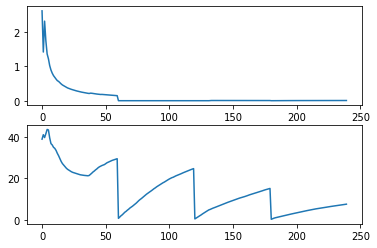

In [9]:
plt.figure()
fig, axs = plt.subplots(2)
axs[0].plot(all_D_losses)
axs[1].plot(all_G_losses)

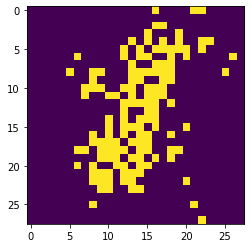

In [13]:
# Test

noise = torch.randn(1, 10 * 10).to(device)
generated_image = G(noise).view(28, 28).cpu().detach()


imshow(generated_image)


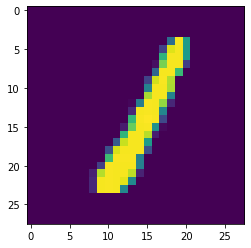

In [11]:
dataiter = iter(trainloader)

while(True):
    images, labels = dataiter.next()
    if labels[0] == 1:
        images = images.view(28, 28)
        imshow(images)
        break